In [1]:
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift, fft, ifft
import soundfile as sf
from scipy.signal import hann


#KYW inst
fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final_Project/Music-Technology-Final-Project/Sound Examples/KYW Inst.wav')
#ATF Drums
#fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final_Project/Music-Technology-Final-Project/Sound Examples/Around the fur drums.wav')

# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


## Comb filter

In [2]:
fc = 2000
Q = 30

b, a = signal.iircomb(fc, Q, ftype='peak', fs=fs)

w, H = signal.freqz(b, a)


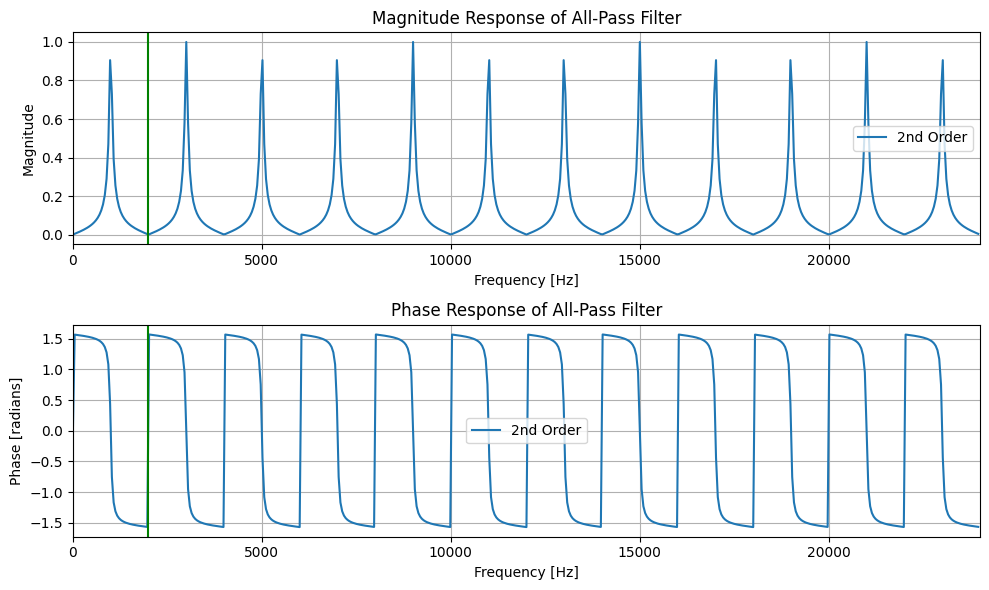

In [3]:
freq_hz = w * (fs / (2 * np.pi))

# Plot magnitude and phase responses in Hz
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_hz, np.abs(H), label='2nd Order')
plt.title('Magnitude Response of All-Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(which='both')
#plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits
plt.axvline(fc, color='green')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(freq_hz, np.angle(H), label='2nd Order')
plt.title('Phase Response of All-Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.grid(which='both')
#plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits
plt.axvline(fc, color='green')
plt.legend()


plt.tight_layout()
plt.show()

In [4]:
filtered = signal.lfilter(b, a, data)

In [5]:
sd.play(filtered, fs)

## Using delay line

In [6]:
#Implementation from pirkles book
from CircularBuffer import CircularBuffer, StereoDelay

delay_amt = 0.05 #in seconds
delay_amt_samples = delay_amt * fs

delayLine = StereoDelay(delay_amt_samples, delay_amt_samples)

g = 0.6

output = np.zeros((len(data), 2))

for i in range(len(data)):
    delayed = delayLine.get_samples_from_buffer()

    output[i] = delayed

    delayed = np.multiply(delayed, g)

    delayLine.push_samples_to_buffer(delayed + data[i])


#normalise
max_amplitude = np.max(np.abs(output))
normalized_output_1 = output / max_amplitude


In [7]:
sd.play(normalized_output_1, fs)

## Windowing Signals and plotting response of filter

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_46480/3868238433.py:2: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(len(data))


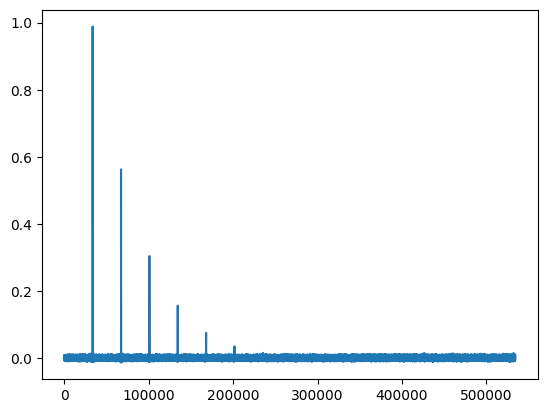

In [8]:
# Apply windowing
window = hann(len(data))
original_signal = data[:,0] * window
filtered_signal = output[:,0] * window

original_spectrum = fft(original_signal)
filtered_spectrum = fft(filtered_signal)

epsilon = 1e-10

impulse_response_spectrum = filtered_spectrum/(original_spectrum + epsilon)

impulse_response = np.real(ifft(impulse_response_spectrum))

plt.plot(impulse_response)

## Comb Filter Reverberator

Combining multiple comb filters in parallel with different delays and feedback gain amounts can give us a reverb

In [9]:
N = 4
parallel_delayLines = [None] * N
gains = [0.6, 0.4, 0.3, 0.2]
delays = [0.03, 0.05, 0.07, 0.1]

output2 = np.zeros((len(data), 2))

# initialise delay lines
for i in range(N):
    parallel_delayLines[i] = StereoDelay((delays[i] * fs), (delays[i] * fs)+300)



for j in range(N):
    for i in range(len(data)):

        delayed = 0

        delayed = parallel_delayLines[j].get_samples_from_buffer()

        output2[i] += delayed

        delayed = np.multiply(delayed, gains[j])

        parallel_delayLines[j].push_samples_to_buffer(delayed + data[i])




#normalise
max_amplitude = np.max(np.abs(output2))
normalized_audio = output2 / max_amplitude

In [10]:
sd.play(normalized_audio)